In [10]:
import os
import shutil
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path(os.path.join("..", "..", "dataset", "cats_vs_dogs_small"))


image_size = (180, 180)
batch_size = 32
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size=image_size, batch_size=batch_size
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size=image_size, batch_size=batch_size
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size=image_size, batch_size=batch_size
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [12]:
conv_base.trainable = False
for layer in conv_base.layers[-4:]:
    conv_base.trainable = True

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.2),
    ]
)

In [14]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

In [15]:
from tensorflow.keras import optimizers
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"],
)


In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]


In [17]:

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30


2022-10-06 15:10:27.083721: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-06 15:10:27.819417: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


63/63 [==============================] - 46s 543ms/step - loss: 2.1410 - accuracy: 0.5200 - val_loss: 0.7017 - val_accuracy: 0.5130
Epoch 2/30
63/63 [==============================] - 31s 490ms/step - loss: 0.7160 - accuracy: 0.5175 - val_loss: 0.6745 - val_accuracy: 0.5750
Epoch 3/30
63/63 [==============================] - 31s 485ms/step - loss: 0.6752 - accuracy: 0.5755 - val_loss: 0.5722 - val_accuracy: 0.6910
Epoch 4/30
63/63 [==============================] - 31s 485ms/step - loss: 0.6004 - accuracy: 0.6630 - val_loss: 0.4415 - val_accuracy: 0.8390
Epoch 5/30
63/63 [==============================] - 31s 486ms/step - loss: 0.5008 - accuracy: 0.7610 - val_loss: 0.3328 - val_accuracy: 0.8820
Epoch 6/30
63/63 [==============================] - 31s 487ms/step - loss: 0.4526 - accuracy: 0.8000 - val_loss: 0.2455 - val_accuracy: 0.9280
Epoch 7/30
63/63 [==============================] - 31s 487ms/step - loss: 0.3358 - accuracy: 0.8640 - val_loss: 0.2061 - val_accuracy: 0.9330
Epoch 8/30

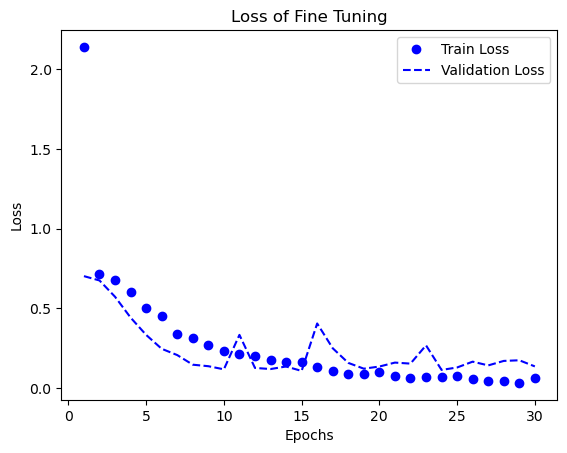

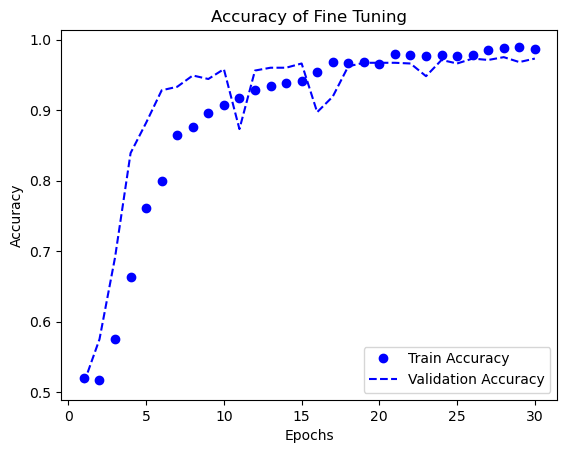

In [19]:
import matplotlib.pyplot as plt

x_range = range(1, 31)
plt.plot(x_range, history.history["loss"], "bo", label="Train Loss")
plt.plot(x_range, history.history["val_loss"], "b--", label="Validation Loss")
plt.title("Loss of Fine Tuning")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.plot(x_range, history.history["accuracy"], "bo", label="Train Accuracy")
plt.plot(x_range, history.history["val_accuracy"], "b--", label="Validation Accuracy")
plt.title("Accuracy of Fine Tuning")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
